In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from art.utils import load_mnist, preprocess

import os
import copy

from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

from tqdm import tqdm

c:\Users\loren\anaconda3\envs\fed-learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_path = 'models/model.pt'

#### FL Fusion Class Selection

In [3]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [4]:
num_parties = 5
scale = 1
#Select the party that I would like to erase (ex: 3)
party_to_be_erased = 0

num_samples_erased_party = int(60000 / num_parties * scale)
num_samples_per_party = int((60000 - num_samples_erased_party)/(num_parties - 1))
print('Number of samples erased party:', num_samples_erased_party)
print('Number of samples other party:', num_samples_per_party)

Number of samples erased party: 12000
Number of samples other party: 12000


### 2. Load data
<a id='section_2'></a>

In [5]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

Create Trainloader

In this Notebook we are going to create it by the following principle:
 - Each client will have 50% of it's dataset given by classes common among all the clients
 - Remaining 50% will be given to each client and will be different among different clients

Example:
client 3 will have 50% given by the labels: [0,1,2,3,4]. 50% will be with data coming just from the label [7]

In [6]:
all_indices = np.arange(len(y_train))
common_classes_indices = all_indices[np.sum(y_train*np.array([1,1,1,1,1,0,0,0,0,0]), axis = 1).astype(bool)]
list_clients_dataset_indices = np.split(common_classes_indices[:-(len(common_classes_indices)%5)], 5)

for i in range(5,10):
  label = [0,0,0,0,0,0,0,0,0,0]
  label[i] = 1
  indx = all_indices[np.sum(y_train*np.array(label), axis = 1).astype(bool)]
  list_clients_dataset_indices[i-5] = np.concatenate((list_clients_dataset_indices[i-5], indx[:len(indx)//5]))

x_train_ch = np.expand_dims(x_train, axis=1)
y_train_c = np.argmax(y_train, axis=1).astype(int)
trainloader_lst = []
for indices in list_clients_dataset_indices:
  ds = TensorDataset(torch.Tensor(x_train_ch[indices]), torch.Tensor(y_train_c[indices]).long())
  trainloader_lst.append(DataLoader(ds, batch_size=128, shuffle=True))

x_test_pt = np.expand_dims(x_test, axis = 1)
y_test_pt = np.argmax(y_test,axis=1).astype(int)
dataset_test = TensorDataset(torch.Tensor(x_test_pt), torch.Tensor(y_test_pt).long())
testloader = DataLoader(dataset_test, batch_size=1000, shuffle=False)

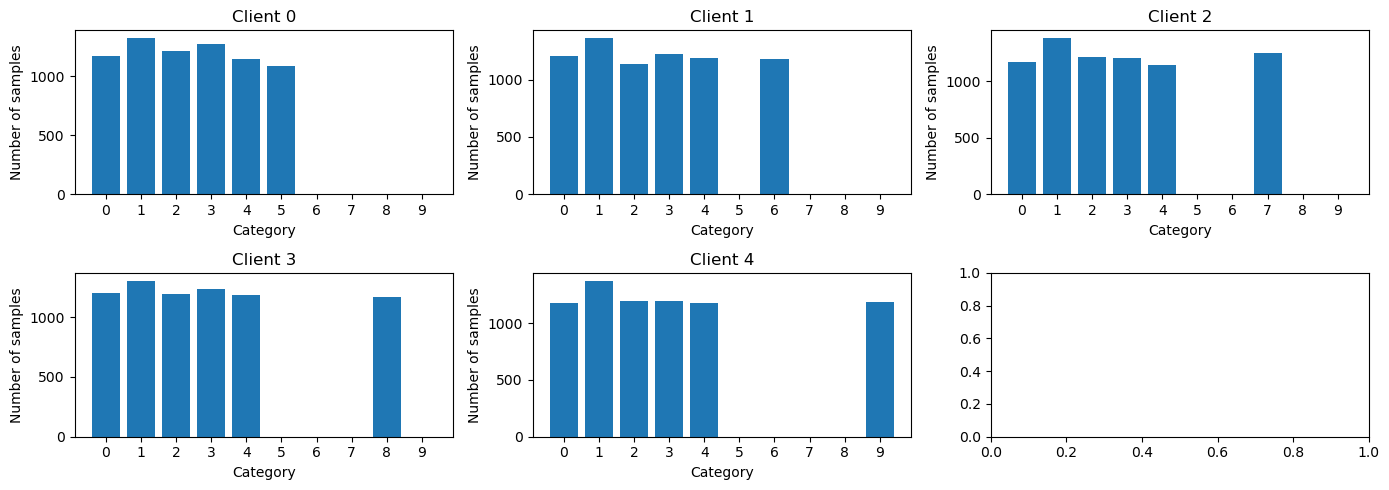

In [7]:
client_stats=[[]for i in range(5)]
for client in range(5):
    for category in range(10):
        client_indices=list_clients_dataset_indices[client]
        count=0
        for i in client_indices:
            if y_train_c[i]==category:
                count+=1
        client_stats[client].append(count)

axs = fig, axs = plt.subplots(2, 3, figsize=(14, 5))
for i,client in enumerate(client_stats):
    axs[i//3][i%3].bar(range(10),client)
    axs[i//3][i%3].set_title('Client '+str(i))
    axs[i//3][i%3].set_xticks(range(10))
    axs[i//3][i%3].set_xticklabels(range(10))
    axs[i//3][i%3].set_xlabel('Category')
    axs[i//3][i%3].set_ylabel('Number of samples')

plt.tight_layout()
plt.show()


## 2. Train the FL Model
<a id='section_3'></a>

In [8]:
num_of_repeats = 1
num_fl_rounds = 50

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 1

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

Train and evaluate the FL Model

In [9]:
class FLNet2(nn.Sequential):
    def __init__(self):
        super(FLNet2, self).__init__(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

In [10]:
saved_model = FLNet2()
saved_model.load_state_dict(torch.load(load_path, weights_only=True))

<All keys matched successfully>

In [11]:
def create_dataloader(idx_client, _list_trainloader, percentage_to_remove):
    list_trainloader = copy.deepcopy(_list_trainloader)
    client_dataset = list_trainloader[idx_client].dataset

    num_samples_to_remove = int(len(client_dataset) * percentage_to_remove)
    num_samples_to_keep = len(client_dataset) - num_samples_to_remove
    
    if num_samples_to_keep != 0:
        new_dataset = TensorDataset(client_dataset[:num_samples_to_keep][0], client_dataset[:num_samples_to_keep][1])
        list_trainloader[idx_client] = DataLoader(new_dataset, batch_size=128)

    else:
        list_trainloader.pop(idx_client)

    return list_trainloader, num_samples_to_remove

In [12]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

trainloader_list = [DataLoader(dloader.dataset, batch_size=128) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(saved_model)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

special_weight = 0.01

# Calculate equal weights for others
other_weight = 1

# Create weights list
weights = [other_weight] * len(trainloader_list)
weights[party_to_be_erased] = special_weight


Compute Hessians

In [16]:
def compute_diag_hessian_bis(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian_bis(loader, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Store Hessians and batch counts per client
    total_batches = 0

    # Calculate diagonal Hessian for each client
    accumulated_diag_h = {}
    
    for batch_idx, (inputs, targets) in enumerate(loader):
        # Compute diagonal Hessian for this batch
        diag_h = compute_diag_hessian_bis(model, criterion, inputs, targets, device=device)
        
        # Accumulate values
        for name, value in diag_h.items():
            if name not in accumulated_diag_h:
                accumulated_diag_h[name] = value
            else:
                accumulated_diag_h[name] += value
        
        total_batches += 1
    
    # Compute average of client Hessians
    avg_hessian = {}
    for name in accumulated_diag_h.keys():
        avg_hessian[name] = accumulated_diag_h[name]/ total_batches
    
    return avg_hessian


In [17]:
def compute_diag_hessian_naive_subset(model, criterion, dataloader, device='cpu'):
    """
    Compute the diagonal of the Hessian for a subset of parameters (here: "0.weight", "3.weight", "3.bias")
    using a naive approach. Only the allowed parameters are used in the Hessian computation,
    reducing memory usage.
    """
    # Define the allowed parameter names:
    allowed_names = ["0.weight"]#["0.weight", "3.weight", "9.weight"]
    
    device = 'cuda' if torch.cuda.is_available() else device
    model.to(device)

    accumulated_diag_h = {}
    total_batches = 0
    
    pbar = tqdm(total=len(dataloader), desc="Computing Hessian Diagonal")
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Filter model parameters to only those in allowed_names
        allowed_named_params = [(name, param) for name, param in model.named_parameters() if name in allowed_names]
        allowed_params = [param for name, param in allowed_named_params]
        
        # Compute first derivatives for the allowed parameters with create_graph=True for second derivatives.
        grads = torch.autograd.grad(loss, allowed_params, create_graph=True)

        diag_hessian = {}
        
        # For each allowed parameter, compute the element-wise second derivative (diagonal).
        for (name, param), grad_param in zip(allowed_named_params, grads):
            if not param.requires_grad:
                continue

            grad_param_flat = grad_param.contiguous().view(-1)
            diag_elements = []

            for i in range(grad_param_flat.size(0)):
                # Compute the second derivative of grad_param_flat[i] with respect to param.
                second_deriv = torch.autograd.grad(
                    grad_param_flat[i],
                    param,
                    retain_graph=True
                )[0]
                diag_i = second_deriv.view(-1)[i]
                diag_elements.append(diag_i.detach())

            diag_tensor = torch.stack(diag_elements).view(param.size())
            diag_hessian[name] = diag_tensor.cpu()

        for name, value in diag_hessian.items():
            if name not in accumulated_diag_h:
                accumulated_diag_h[name] = value.clone()
            else:
                accumulated_diag_h[name] += value

        total_batches += 1
        pbar.update(1)
    pbar.close()

    # Compute average of client Hessians
    avg_hessian = {}
    for name in accumulated_diag_h.keys():
        avg_hessian[name] = accumulated_diag_h[name]/ total_batches

    return avg_hessian

In [18]:
torch.cuda.empty_cache()
#Computation of Hessian for Dataloader 0 with Backpack
hes_0 = calculate_accumulated_diag_hessian_bis(trainloader_list[0], final_model, criterion)


In [19]:
#Computation of Hessian for Dataloader 0 with True Hessian
final_model = copy.deepcopy(saved_model)
criterion = nn.CrossEntropyLoss()

diag_hess = compute_diag_hessian_naive_subset(final_model, criterion, trainloader_list[0], device='cuda')


Computing Hessian Diagonal: 100%|██████████| 57/57 [06:15<00:00,  6.59s/it]


In [20]:
import torch.nn.functional as F
param_name = "0.weight"

mse = F.mse_loss(hes_0[param_name].cpu(), diag_hess[param_name].cpu(), reduction='none')  # shape: [32, 1, 5, 5]
per_sample_mse = mse.view(32, -1).mean(dim=1)  
print(per_sample_mse.mean())

rel_error = (hes_0[param_name].cpu() - diag_hess[param_name].cpu()).abs() / (diag_hess[param_name].abs())  # shape: [32, 1, 5, 5]
rel_error_per_sample = rel_error.view(32, -1).mean(dim=1)
print(rel_error_per_sample)

tensor(1.9991e-16)
tensor([1.8303e-05, 9.4111e-05, 2.4071e-05, 9.1607e-06, 1.6310e-05, 2.5489e-05,
        1.9875e-05, 1.6474e-05, 5.6415e-05, 2.3620e-05, 1.9699e-05, 9.1895e-05,
        5.7654e-05, 2.8613e-05, 1.5862e-05, 2.9592e-05, 3.1000e-05, 2.0570e-04,
        1.8633e-05, 4.0282e-05, 4.0537e-05, 5.5056e-05, 2.9949e-05, 1.3582e-05,
        2.0634e-05, 3.9992e-05, 1.7402e-05, 6.4195e-05, 5.9748e-05, 1.2415e-05,
        3.5736e-05, 9.0496e-05])


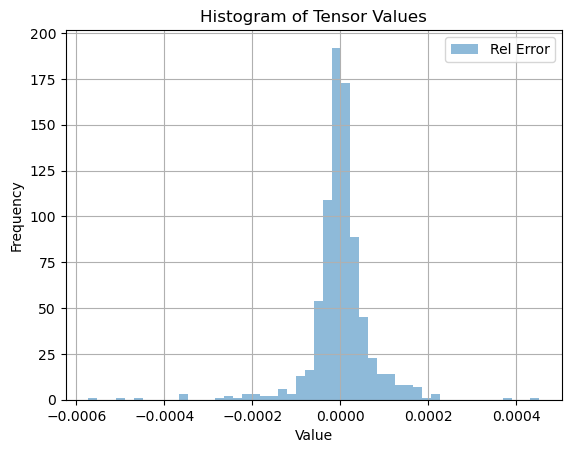

In [21]:
flat_a = (hes_0[param_name].cpu() - diag_hess[param_name].cpu())/ diag_hess[param_name]                                                         
flat_a = flat_a.view(-1).cpu().numpy()
# Plot histograms
plt.hist(flat_a, bins=50, alpha=0.5, label='Rel Error')
plt.legend()
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()